# Fitting Thomson Scattering Spectrum

In [1]:
%matplotlib inline
import ts_analysis as TsA
import matplotlib.pyplot as plt
import os
import numpy as np

# s0823_18 g23

### 1A: Load data and view raw spectrogram
First, you need to provide raw data in the form of a .asc file (plain ASCII, tab delimited) exported by Andor Solis for both the high power background and the shot. The background is used to calibrate the fibres. You can provide as many background files as you wish - the raw images are summed together. This is especially useful if you have pin scattering measurements for individual fibres, as the signal to noise ratio is far better than the high power background where the light scatters off particles in the vacuum chamber. To create a Thomson Scattering Analysis object, we use:

`ts=TsA.TS_Analysis('folder/shot_filename.asc',['folder/background_file1.asc','folder/background_file2.asc'])`

`ts` is an object that knows about the data in the files. 

No electron density file found, enter electron densities manually.
No electron density file found, enter electron densities manually.


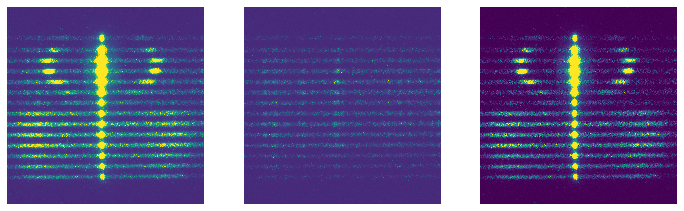

In [5]:
folder=r"example_data"
shot_fn='g023.asc'
se_fn='g022.asc'
bk_fn='gain3000slit120um.asc'
ts=TsA.TS_Analysis(folder, shot_fn,[bk_fn])
ts_se=TsA.TS_Analysis(folder, se_fn,[bk_fn]) # create a new TS object for the self emission

diff = ts.shot-ts_se.shot # the difference between the self emission and the shot

# plot a triptych showing the shot, the self emission and the difference
fig, ax = plt.subplots(1,3, figsize=(12,8))
clim=[0,2e3] #adjust clim to get a good contrast on the image
ax[0].imshow(ts.shot, clim=clim, cmap='viridis', aspect='equal') 
ax[1].imshow(ts_se.shot, clim=clim, cmap='viridis', aspect='equal')
ax[2].imshow(diff, clim=clim, cmap='viridis', aspect='equal')

for a in ax:
    a.set_axis_off()


In [6]:
# replace the shot with the shot-self emission
ts.shot=diff

#### 1B: Find fibre edges on spectrometer CCD
`ts` starts by asking you where the fibre edges are. A graph appears on the screen with two sliders labelled `spacing` and `offset`. `spacing` is the number of pixels per fibres and `offset` is where the first fibre begins. Move the sliders so that the red dots lie in between each fibre in the minima. It is difficult to get the red dots perfect for every fibre, but this only amounts to an error of 1 pixel, so it is not significant.

In [7]:
#You can write the correct spacing and offset here to remind yourself what to use when you rerun the code:
#spacing 55, offset 132
ts.find_fibre_edges()

interactive(children=(FloatSlider(value=18.0, description='spacing', max=60.0, min=10.0), IntSlider(value=8, d…

### 1C: Specify fibre angles and split CCD into separate fibres
Once we have told `ts` where the fibre edges are, it can split the background and shot images into fibres and average over the pixels that correspond to each fibre:

`split_into_fibres(discard_rows=6, dark_counts = None, dark_x=300, intensity_x=60, fibres = 28):` 

* Discard rows is useful to get rid of low signal:noise ratio rows at the top and bottom of each fibre. You can discard the first and last n rows of each fibre to avoid averaging over this noise.
* dark_counts allows you to manually set the dark counts on the CCD. In this example, we find the dark counts in a small square in the top left where there is no signal.
* if you set dark_counts to None, you need to set dark_x, and the code will take the average dark counts in a strip [:,:x] and [:, -x:]. If you have no dark strips (for example, with the new spectrometer), use dark_counts instead.
* intensity_x is used to normalise the fibres, using the intensity in [mx-intensity_x:mx+intensity_x], where mx is the centre of the CCD. So if your signal is in a narrow region, like with IAW, use intensity_x=60 or so. For EPW the entire width of the CCD, so 250 or so.
* fibres: set the number of fibres you can see on the CCD. Usually 14 or 28.

`ts.zero_fibres(upper=1150, lower=850)` Trim the data to the edge of the active CCD region. Defaults are for IAW on the old spectrometer. This example file for EPW uses the entire CCD.

`ts.pair_fibres(a_angle,b_angle)` pair the background and shot fibres together, assign an angle to each fibre bundle. a_angle and b_angle are lists of angles which are N fibres long, eg. [45,45...] 

In [8]:
dark_counts=int(ts.shot[:100,:100].mean())

ts.split_into_fibres(discard_rows=10, dark_counts=dark_counts, dark_x=None, intensity_x=250, fibres=14)

ts.zero_fibres(upper=1024, lower=0)
a_angle=[24]*7 #here we have fibres 1A through 7A at an angle of 24'
b_angle=[90]*7 #here we have fibres 1B through 7B at an angle of 24'
ts.pair_fibres(a_angle,b_angle)

## 2. Determine notch

We want to filter out the 'parasitic' or 'stray' light and the ion feature, which are close to the unshifted wavelength. To do this, we define a synthetic notch filter, which is applied to both the data and the model. You can test what size notch is useful below.

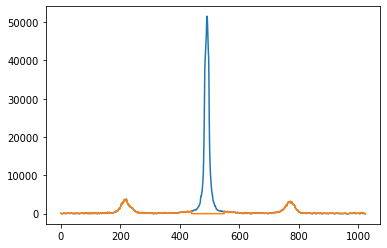

In [10]:
f=ts.select_fibre(4,'A')

fig,ax=plt.subplots()
ax.plot(f.shot)

notch=np.ones_like(f.shot)
notch[440:550]=0 #edit the indices of this array to see the notch below
ax.plot(f.shot*notch)

## 3: Fit spectra
- Specify the fibre to fit using Fnum=(1-14) and Fset=('A' or 'B') (note quote marks)

- Leave the model as 'nLTE', no other models are currently implemented.

- Specify the plasma parameters in the form (Values, Independent?, Minimum value)

- If Independent is True, then the value is fixed and minimum has no meaning. If Independent is False, then the value is an initial guess for the fit and minimum is either a float, or simply ommitted to specify no given minimum.

- Leave A in brackets, eg 'A':  ((12), True). The code will find the relevant nLTE data for Z, T_e and decompose ZT_e into Z and T_e separately.

Once you've fitted the data, the code will remember the fit parameters it used, and instead of refitting you can simply plot or export the data using the next cells.

### Fibre 4A

[[Model]]
    Model(Skw_e_stray_light_convolve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 969
    # variables        = 4
    chi-square         = 1.2441e+08
    reduced chi-square = 128918.531
    Akaike info crit   = 11406.1526
    Bayesian info crit = 11425.6577
##  Warning: uncertainties could not be estimated:
    offset:     at boundary
[[Variables]]
    n_e:        2.4299e+17 (init = 3e+17)
    T_e:        26.0770870 (init = 8.6)
    amplitude:  3356.94079 (init = 3000)
    offset:     0.00000000 (init = 0)


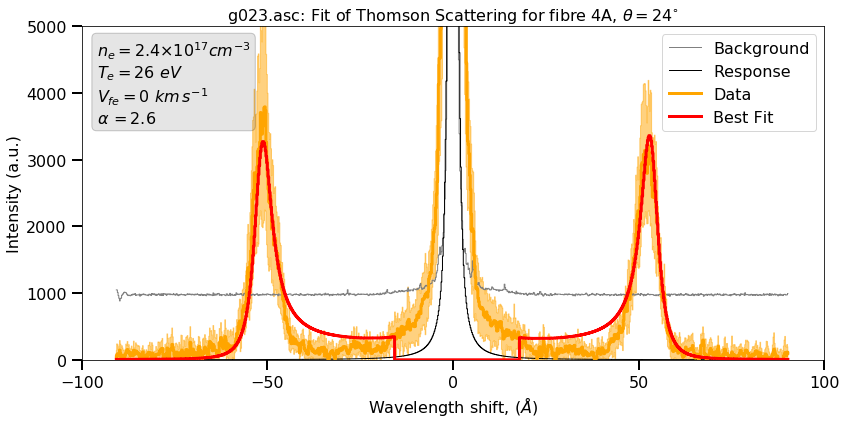

In [17]:
Fnum=4
Fset='A'

plasma_parameters={ 'model': 'electron',
                    'n_e': (3e17,False,1e16),#in cm^-3, must be specified
                    'T_e': (8.6, False,0.5),#In electron volts. 
                    'V_fe':(0, True),#m/s.
                    'stray':(5e4, True,0), #Fraction of signal made up of stray light. >0, <1.0!!
                    'amplitude': (3e3, False,0), #Fraction of signal made up of spectrum.
                    'offset': (0, False,0), #
                    'shift': (0, True)
                    }

'''This code fits and plots the result'''
f=ts.select_fibre(Fnum,Fset)
f.voigt_response(gamma=5e-11,sigma=6e-11)
f.symmetric_crop_around_l0()

notch=np.ones_like(f.shot)
notch[400:580]=0

f.fit_fibre(plasma_parameters, interpolation_scale=10, notch=notch)
f.calculate_alpha()
ts.pretty_plot(Fnum,Fset, tm=1.6, sr=100) #you can change the angstrom range plotted by altering 'sr=' here.
print(f.skw_res.fit_report()) #this prints the fitted values and the fit quality

ts.ax.set_ylim([0,5e3])#
ts.ax.set_xticks([-100,-50,0,50,100]);

### Fibre 4B

In [ ]:
Fnum=4
Fset='B'

plasma_parameters={ 'model': 'electron',
                    'n_e': (3e17,False,1e16),#in cm^-3, must be specified
                    'T_e': (20, False,0.5),#In electron volts. 
                    'V_fe':(0, True),#m/s.
                    'stray':(0, True,0), #Fraction of signal made up of stray light. >0, <1.0!!
                    'amplitude': (3e3, False,0), #Fraction of signal made up of spectrum.
                    'offset': (0, True), #
                    'shift': (0, True)
                    }

'''This code fits and plots the result'''
f=ts.select_fibre(Fnum,Fset)
f.voigt_response()
f.symmetric_crop_around_l0()

notch=np.ones_like(f.shot)
notch[430:550]=0

f.fit_fibre(plasma_parameters, interpolation_scale=10, notch=notch)
f.calculate_alpha()
ts.pretty_plot(Fnum,Fset, tm=1.6, sr=100) #you can change the angstrom range plotted by altering 'sr=' here.
print(f.skw_res.fit_report()) #this prints the fitted values and the fit quality

ts.ax.set_ylim([0,5e3])#
ts.ax.set_xticks([-100,-50,0,50,100]);

### 3A: Plot data
If you've already fitted a fibre and simply want to see the fit again without refitting, use the cell below. You can then save the figure using the next cell. You can change the range of the horizontal access by altering sr=, which is in Angstroms

In [ ]:
ts.pretty_plot(Fnum=4,Fset='A', tm=1.6, sr=6)
ts.ax.set_ylim([0,7e4])#
ts.ax.set_xticks([-100,-50,0,50,100]);

### 3B: Save plot
This saves whichever figure you have generated last, either by fitting (2) or using the plot data cell (3A) above. You can alter the filename

In [ ]:
ts.fig.savefig(ts.s_name+' fibre '+str(Fnum)+Fset+'.png')

### 4: Export data
Save out the fits so you can plot them in another plotting program. Specify the fibre number and the fibre set.

In [ ]:
for Fnum in [1,2,3,4,5,6,7]:
    f=ts.select_fibre(Fnum,'A')
    f.export_data('g23 '+str(Fnum)+'E')
    f=ts.select_fibre(Fnum,'B')
    f.export_data('g23 '+str(Fnum)+'F')

In [ ]:
import csv
def export_fit_parameters(fibres, fn):
    n_e=[]
    n_e_err=[]
    T_e=[]
    T_e_err=[]
    
    headings=('Fibre', 'n_e', 'n_e_err', 'T_e ', 'T_e_err')
    units=('-', ' cm^-3', ' cm^-3','eV','eV')
    with open(fn+'.dat', 'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headings)
        writer.writerow(units)
        for i,fibre in enumerate(fibres):
            try:
                n_e=fibre.skw_res.params['n_e']
                n_e_err=n_e.stderr
                n_e=n_e.value
            except:
                n_e=fibre.params['n_e'] 
                n_e_err=0
            try:
                T_e=fibre.skw_res.params['T_e']
                T_e_err=T_e.stderr
                T_e=T_e.value
            except:
                T_e=fibre.params['T_e']
                T_e_err=0
            row=[i,n_e,n_e_err,T_e,T_e_err]
            writer.writerow(row)       

In [ ]:
export_fit_parameters(ts.fibres_a, fn='g23 E fibre fit parameters')
export_fit_parameters(ts.fibres_b, fn='g23 F fibre fit parameters')

### 5A: Plot all the A fibre data

In [ ]:
for i in range(1,8):
    ts.plot_data(Fnum=i, Fset='A', sr=50)

### 5B: Plot all the B fibre data

In [ ]:
for i in range(1,7):
    ts.plot_data(Fnum=i, Fset='B',sr=50)

### 6: Emcee
Highly experimental. We use the integration of emcee into lmfit to post process our fitting, to understand what possible combinations of parameters could also produce a good fit.

More information:
* https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html
* https://lmfit.github.io/lmfit-py/fitting.html#minimizer-emcee-calculating-the-posterior-probability-distribution-of-parameters
* https://lmfit.github.io/lmfit-py/examples/lmfit_emcee_model_selection.html

In [ ]:
import emcee
import corner

In [ ]:
## Select a fibre for which you have already carried out a good fit.
f=ts.select_fibre(4,'B')

## This dictionary specifies the emcee walkers:
### Steps: number of steps per walker
### Burn: number of initial steps to discard
### nwalkers: number of walkers
### thin: keep 1 in thin steps
### is_weighted: not sure
### progress: a progress bar
### workers: apparently for multiprocessing, this may not work
emcee_kws = dict(steps=2000, burn=200, nwalkers=10,thin=5, is_weighted=False,
                 progress=True, workers=4)

emcee_params = f.skw_res.params.copy()

### This adds an uncertainty parameter, so that we can estimate the noise on the signal. It's in log space,
### so the max/min covers a massive range.
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(3.0))

iv_dict=f.iv_dict.copy()

In [ ]:
### The fitting. This will take a while.

result_emcee = f.skw_res.model.fit(f.shot, **iv_dict, params=emcee_params, method='emcee',fit_kws=emcee_kws)

In [ ]:
### In var, select which variables you want for the corner plot. The corner plot takes a bit of staring at to understand.
### Effectively it's a 2D histogram of possible parameter values for every pairing in var.
### And then the on diagonal images are histograms of each parameter in var
### For uncorrelated parameters, you would get a load of gaussians, in 2D and 1D.
### But oh boy is that not the case with something as complex as Thomson Scattering.
### Good luck.

var=['n_e', 'T_e', 'amplitude']

df=result_emcee.flatchain[var]

emcee_corner = corner.corner(df, labels=var,
                             truths=list(result_emcee.params.valuesdict().values()))